## SKlearn pipeline

Objective is to build an sklearn pipeline on this data, to eventually compare it to tidymodels

Interesting and learning the new tidymodels package? In my laster blog post, I show how common scikit learn workflows translate to tidymodels (and vice versa!)

1. Feature Engineering
2. Model Selection
3. Tuning
    - example of tuning preprocessing step: https://tune.tidymodels.org/articles/getting_started.html
    - example in sklearn: https://gist.github.com/amberjrivera/8c5c145516f5a2e894681e16a8095b5c#use-gridsearchcv-to-identify-the-best-estimator-and-optimize-over-the-entire-pipeline
        - note that `n_components` is feature of PCA that is being tuned
        
        - step_ns: recipes https://recipes.tidymodels.org/reference/step_ns.html
        - sklearn: 
            - https://patsy.readthedocs.io/en/latest/spline-regression.html
            - https://gist.github.com/MMesch/75091113412ff931a611552c64319185#file-robust_2dsplines_sklearn-py-L94

        - sklearn bayesopt: https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html
        
        

4. Evaluation and Examination
    * frankly, scikit learn makes it pretty difficult to understand feature importances. tidymodels comes with a
      a better set of defaults for exploring relevant statistics, setting evaluation parameters, and looking at
      features
      
    * scikit learn, on the other hand, has a much more robust pipeline (workflow in tidymodel terms) system,
      that allows you to tune **any** aspect of the sequence, which is very cool
      


In [6]:
import pandas as pd
import numpy as np

input_data = 's3://sagemaker-sample-data-us-east-2/processing/census/census-income.csv'
df = pd.read_csv(input_data)

In [7]:
model_columns = [
  'age', 'education', 'major industry code', 'class of worker', 
  'num persons worked for employer',
  'capital gains', 'capital losses', 'dividends from stocks', 'income'
]

In [8]:
df = df[model_columns]

In [15]:
income_agg = df.groupby('income').agg({'income': 'count'})
income_agg['prop'] = income_agg.income / income_agg.income.sum()

income_agg

,income,prop
income,,
- 50000.,187141,0.937942
50000+.,12382,0.062058


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_transformer

In [25]:
df.isnull().sum()

age                                0
education                          0
major industry code                0
class of worker                    0
num persons worked for employer    0
capital gains                      0
capital losses                     0
dividends from stocks              0
income                             0
dtype: int64

In [26]:
preprocess = make_column_transformer(
    (KBinsDiscretizer(encode='onehot-dense', n_bins=10), ['age', 'num persons worked for employer'],),
    (StandardScaler(), ['capital gains', 'capital losses', 'dividends from stocks']),
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), ['education', 'major industry code', 'class of worker'])
)

Testing out column processes on data

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('income', axis=1), 
    df['income'], 
    test_size=0.3, 
    random_state=0
)

In [28]:
train_features = preprocess.fit_transform(X_train)

/Users/Tim/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


In [29]:
test_features = preprocess.transform(X_test)

### Feature Engineering

From here, I could save the features to s3 to be used in a feature machine learning algorithm

#### Transformations

I can pull the features out of the transformers (although it's not very nice).

I'd like to be able to see which set of columns were transformed by what. This could be a future package/blog-post

In [30]:
kbin = preprocess.named_transformers_['kbinsdiscretizer']

In [31]:
kbin.bin_edges_

array([array([ 0.,  6., 12., 19., 27., 33., 39., 46., 55., 67., 90.]),
       array([0., 1., 2., 3., 5., 6.])], dtype=object)

In [32]:
kbin.n_bins_

array([10,  5])

In [33]:
ohe = preprocess.transformers_[2][1]

In [34]:
ohe.get_feature_names()

array(['x0_ 10th grade', 'x0_ 11th grade', 'x0_ 12th grade no diploma',
       'x0_ 1st 2nd 3rd or 4th grade', 'x0_ 5th or 6th grade',
       'x0_ 7th and 8th grade', 'x0_ 9th grade',
       'x0_ Associates degree-academic program',
       'x0_ Associates degree-occup /vocational',
       'x0_ Bachelors degree(BA AB BS)', 'x0_ Children',
       'x0_ Doctorate degree(PhD EdD)', 'x0_ High school graduate',
       'x0_ Less than 1st grade',
       'x0_ Masters degree(MA MS MEng MEd MSW MBA)',
       'x0_ Prof school degree (MD DDS DVM LLB JD)',
       'x0_ Some college but no degree', 'x1_ Agriculture',
       'x1_ Armed Forces', 'x1_ Business and repair services',
       'x1_ Communications', 'x1_ Construction', 'x1_ Education',
       'x1_ Entertainment', 'x1_ Finance insurance and real estate',
       'x1_ Forestry and fisheries', 'x1_ Hospital services',
       'x1_ Manufacturing-durable goods',
       'x1_ Manufacturing-nondurable goods',
       'x1_ Medical except hospital', 'x1_ Mi

### sklearn pipeline

In [35]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

In [36]:
model = make_pipeline(
    preprocess,
    LogisticRegression()
)

In [37]:
model.fit(X_train, y_train)

/Users/Tim/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Tim/anaconda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('kbinsdiscretizer',
                                                  KBinsDiscretizer(encode='onehot-dense',
                                                                   n_bins=10),
                                                  ['age',
                                                   'num persons worked for '
                                                   'employer']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['capital gains',
                                                   'capital losses',
                                                   'dividends from stocks']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                

In [38]:
model.score(X_test, y_test)

0.9492289957732596

In [39]:
def model_stats(model, X_test, y_test):
    prob = model.predict_proba(X_test)[:,1]
    pred = model.predict(X_test)
    
    print("roc: {:.2f}".format(roc_auc_score(y_test, prob)))
    print("prc: {:.2f}".format(average_precision_score(y_test, prob, pos_label=' 50000+.')))
    print()
    print(classification_report(y_test, pred))
    

### Metrics and Predictions

In [40]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, average_precision_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, plot_roc_curve

In [41]:
model.classes_

array([' - 50000.', ' 50000+.'], dtype=object)

In [42]:
def model_stats(model, X_test, y_test):
    prob = model.predict_proba(X_test)[:,1]
    pred = model.predict(X_test)
    
    print("roc: {:.2f}".format(roc_auc_score(y_test, prob)))
    print("prc: {:.2f}".format(average_precision_score(y_test, prob, pos_label=' 50000+.')))
    print()
    print(classification_report(y_test, pred))
    
    
model_stats(model, X_test, y_test)

roc: 0.93
prc: 0.54

              precision    recall  f1-score   support

    - 50000.       0.96      0.99      0.97     56237
     50000+.       0.70      0.28      0.40      3620

    accuracy                           0.95     59857
   macro avg       0.83      0.64      0.69     59857
weighted avg       0.94      0.95      0.94     59857



Precision: number of true positives out of all labeled positives

Recall: number of true positives of our all actual positives

Is there a need to identify every positive (increase recall) because True Positives are bad, our Precision will go down.

> PR curves are specifically tailored for the detection of rare events and are pretty useful in those scenarios. 

https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/
What is the 'no-skill' thershold for imbalanced classification on a PR curve? It has to do better than making random guesses based on the base rate of true positives.

In [43]:
income_agg

,income,prop
income,,
- 50000.,187141,0.937942
50000+.,12382,0.062058


We have a good ROC score, but our example is very imbalanced. 

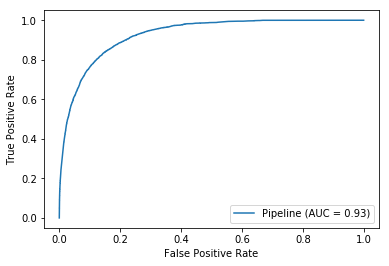

In [46]:
plot_roc_curve(model, X_test, y_test)

If we instead look at a PR curve, we see that the predictor doesn't do very well predicting the positive class.

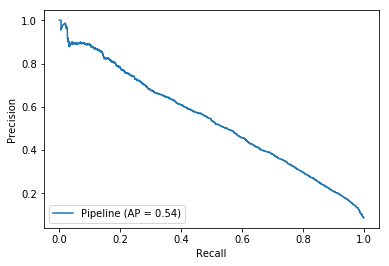

In [45]:
plot_precision_recall_curve(model, X_test, y_test)

### Other models
Because it's so imbalanced, and our ability to identify positive classes is no better than chance, let's try a different model. We can reuse our previous transformation pipeline and plug in a new model.

In [47]:
from sklearn.ensemble import RandomForestClassifier

model_rf = make_pipeline(
    preprocess,
    RandomForestClassifier(n_estimators=500)
)

In [48]:
model_rf.fit(X_train, y_train)

/Users/Tim/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('kbinsdiscretizer',
                                                  KBinsDiscretizer(encode='onehot-dense',
                                                                   n_bins=10),
                                                  ['age',
                                                   'num persons worked for '
                                                   'employer']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['capital gains',
                                                   'capital losses',
                                                   'dividends from stocks']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                

In [49]:
model_stats(model_rf, X_test, y_test)

roc: 0.90
prc: 0.50

              precision    recall  f1-score   support

    - 50000.       0.96      0.98      0.97     56237
     50000+.       0.60      0.38      0.47      3620

    accuracy                           0.95     59857
   macro avg       0.78      0.68      0.72     59857
weighted avg       0.94      0.95      0.94     59857



So without tuning the Random forest model, it's doing signfnicantly worse than our logistic regression

### Cross Validation

In [50]:
from sklearn.model_selection import GridSearchCV

In [51]:
param_grid = {'randomforestclassifier__max_features': [5, 12, 25, 40]}

In [54]:
model_rf_grid = GridSearchCV(model_rf, param_grid, cv=5)

In [55]:
model_rf_grid.fit(X_train, y_train)

/Users/Tim/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Tim/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Tim/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Tim/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bin

KeyboardInterrupt: 

In [ ]:
model_rf_grid.best_params_

In [ ]:
model_stats(model_rf_grid.best_estimator_, X_test, y_test)

In [ ]:
model_rf_grid.cv_results_

For comparsion, let's also fit a classifier that guesses based on the base rate of true positives.

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
model_dummy = make_pipeline(
    preprocess,
    DummyClassifier()
)

In [ ]:
model_dummy.fit(X_train, y_train)

In [ ]:
model_stats(model_dummy, X_test, y_test)

### Model Selection
https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf

Looping through classifiers and adding into pipeline.

Can also use pipelines to cv preprocessing steps: https://gist.github.com/amberjrivera/8c5c145516f5a2e894681e16a8095b5c#use-gridsearchcv-to-identify-the-best-estimator-and-optimize-over-the-entire-pipeline

### Feature Importance

In [56]:
rf = model_rf.named_steps['randomforestclassifier']

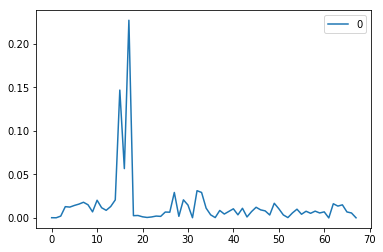

In [57]:
pd.DataFrame(rf.feature_importances_).plot()

So we know some features are much, much more important. But how do we get them? The labels aren't named as in tidymodels. Unfortunately, we have to dig into the column transformation pipeline. Luckily, the transformations are done in order, so it's not impossible to figure out. 

But there is no systematic way of pulling them out. We have to go one at a time.

In [72]:
def make_column_features(columns, features=None):
    if features is None:
        features = columns
    
    return pd.DataFrame({'column': columns, 'feature': features})

In [86]:
_, kbin, kbin_columns = preprocess.transformers_[0]

In [87]:
_, scale, scale_columns = preprocess.transformers_[1]

In [88]:
_, ohe, ohe_columns = preprocess.transformers_[2]

In [91]:
column_feature_names = [
    (kbin_columns, [features[1:] for features in kbin.bin_edges_]),
    (scale_columns, None),
    (ohe_columns, ohe.categories_)
]

In [94]:
column_df = pd.concat([make_column_features(transform[0], transform[1]) for transform in column_feature_names])

In [104]:
column_df = column_df.explode('feature')

In [105]:
column_df

,column,feature
0,age,6
0,age,12
0,age,19
0,age,27
0,age,33
...,...,...
2,class of worker,Private
2,class of worker,Self-employed-incorporated
2,class of worker,Self-employed-not incorporated
2,class of worker,State government


In [117]:
column_df['column_feature'] = column_df['column'] + column_df['feature'].apply(str)

In [119]:
column_df['rf_importance'] = rf.feature_importances_

In [120]:
column_df = column_df.sort_values('rf_importance', ascending=False)

In [121]:
column_df.head()

,column,feature,rf_importance,glm_coef,glm_coef_sort,column_feature
1,num persons worked for employer,5,0.226851,-1.118718,1.118718,num persons worked for employer5.0
2,dividends from stocks,dividends from stocks,0.146717,-1.146113,1.146113,dividends from stocksdividends from stocks
0,capital gains,capital gains,0.056613,-1.144112,1.144112,capital gainscapital gains
0,age,33,0.031262,-0.569471,0.569471,age33.0
1,major industry code,Private household services,0.029223,-0.568189,0.568189,major industry code Private household services


In [122]:
import seaborn as sns

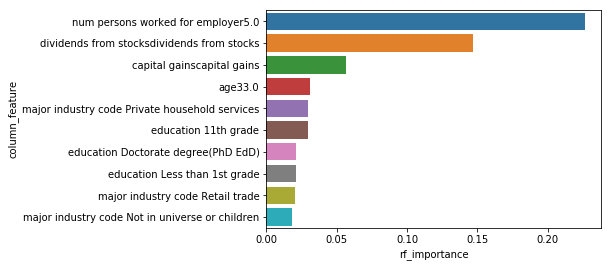

In [123]:
sns.barplot(x='rf_importance', y='column_feature', data=column_df.head(10))

In [124]:
glm = model.named_steps['logisticregression']

In [125]:
column_df['glm_coef'] = glm.coef_[0]

In [126]:
column_df['glm_coef_sort'] = abs(column_df.glm_coef)

In [127]:
column_df = column_df.sort_values('glm_coef_sort', ascending=False)

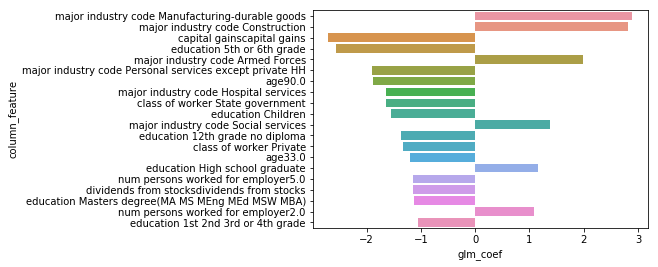

In [129]:
sns.barplot(x='glm_coef', y='column_feature', data=column_df.head(20))

Which columns produced the most impact?

In [140]:
column_df.groupby('column')[['rf_importance', 'glm_coef']] \
    .agg(['mean', 'sum']) \
    .sort_values(('rf_importance', 'sum'), ascending=False)

rf_importance            glm_coef          
                                         mean       sum      mean       sum
column                                                                     
num persons worked for employer      0.047184  0.235921  0.030871  0.154354
major industry code                  0.009110  0.218642  0.209820  5.035676
education                            0.011027  0.187465 -0.211868 -3.601752
dividends from stocks                0.146717  0.146717 -1.144112 -1.144112
age                                  0.008734  0.087335 -0.498084 -4.980839
class of worker                      0.007244  0.065199 -0.125551 -1.129963
capital gains                        0.056613  0.056613 -2.708689 -2.708689
capital losses                       0.002107  0.002107 -0.474273 -0.474273

In [186]:
transformed_column_df = column_df.groupby('column').filter(lambda x: len(x) > 1)

/Users/Tim/anaconda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


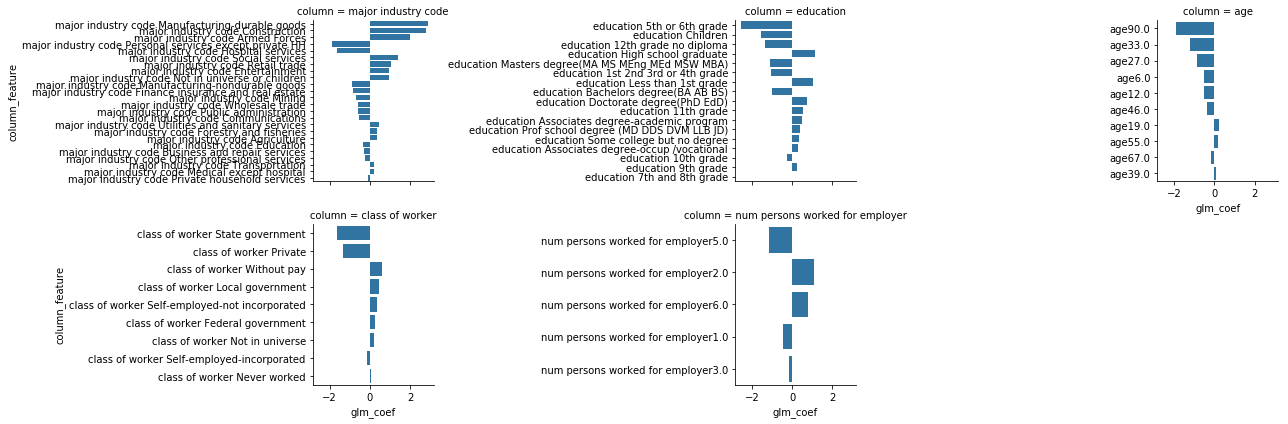

In [215]:
g = sns.FacetGrid(data=transformed_column_df, col='column', sharey=False, col_wrap=3, aspect=2)
g.map(sns.barplot, 'glm_coef', 'column_feature')